In [91]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#loading_data
train=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test= pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
train.drop(['PoolArea'],axis=1,inplace=True)
test.drop(['PoolArea'],axis=1,inplace=True)

In [92]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [93]:
#Creating functions
def missing_val_show(df):
    total_rows=len(df)
    missing_info = df.isnull().sum().reset_index()
    missing_info.columns = ['column_name', 'missing_count']
    missing_info['missing_percentage'] = (missing_info['missing_count'] / total_rows) * 100
    missing_info = missing_info[missing_info['missing_count'] > 0]
    print(missing_info)
    return missing_info
    

missing_info= missing_val_show(train)   
columns_to_drop = missing_info[missing_info['missing_percentage'] > 30]['column_name']
train = train.drop(columns=columns_to_drop)
test = test.drop(columns=columns_to_drop)


# Identify categorical and numerical columns
def col_type(df):
    # Identify categorical and numerical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns 
    print("Categorical_cols: " + str(len(categorical_columns)))
    print("Numerical_cols: " + str(len(numerical_columns)))
    return categorical_columns, numerical_columns

categorical_columns, numerical_columns = col_type(train)

train['LotFrontage'] = train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test['LotFrontage'] = test.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
# Fill missing values
def fill_blank(df):
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            df[col].fillna(train[col].median(), inplace=True)  # Or use mean
        elif df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)

fill_blank(train)
missing_val_show(train)


     column_name  missing_count  missing_percentage
3    LotFrontage            259           17.739726
6          Alley           1369           93.767123
25    MasVnrType            872           59.726027
26    MasVnrArea              8            0.547945
30      BsmtQual             37            2.534247
31      BsmtCond             37            2.534247
32  BsmtExposure             38            2.602740
33  BsmtFinType1             37            2.534247
35  BsmtFinType2             38            2.602740
42    Electrical              1            0.068493
57   FireplaceQu            690           47.260274
58    GarageType             81            5.547945
59   GarageYrBlt             81            5.547945
60  GarageFinish             81            5.547945
63    GarageQual             81            5.547945
64    GarageCond             81            5.547945
71        PoolQC           1453           99.520548
72         Fence           1179           80.753425
73   MiscFea

,column_name,missing_count,missing_percentage


Highly correlated columns: ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea']
Remaining rows train: 1331
Remaining columns train: 74
Remaining rows test: 1459
Remaining columns test: 73
Skewed columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'SalePrice']


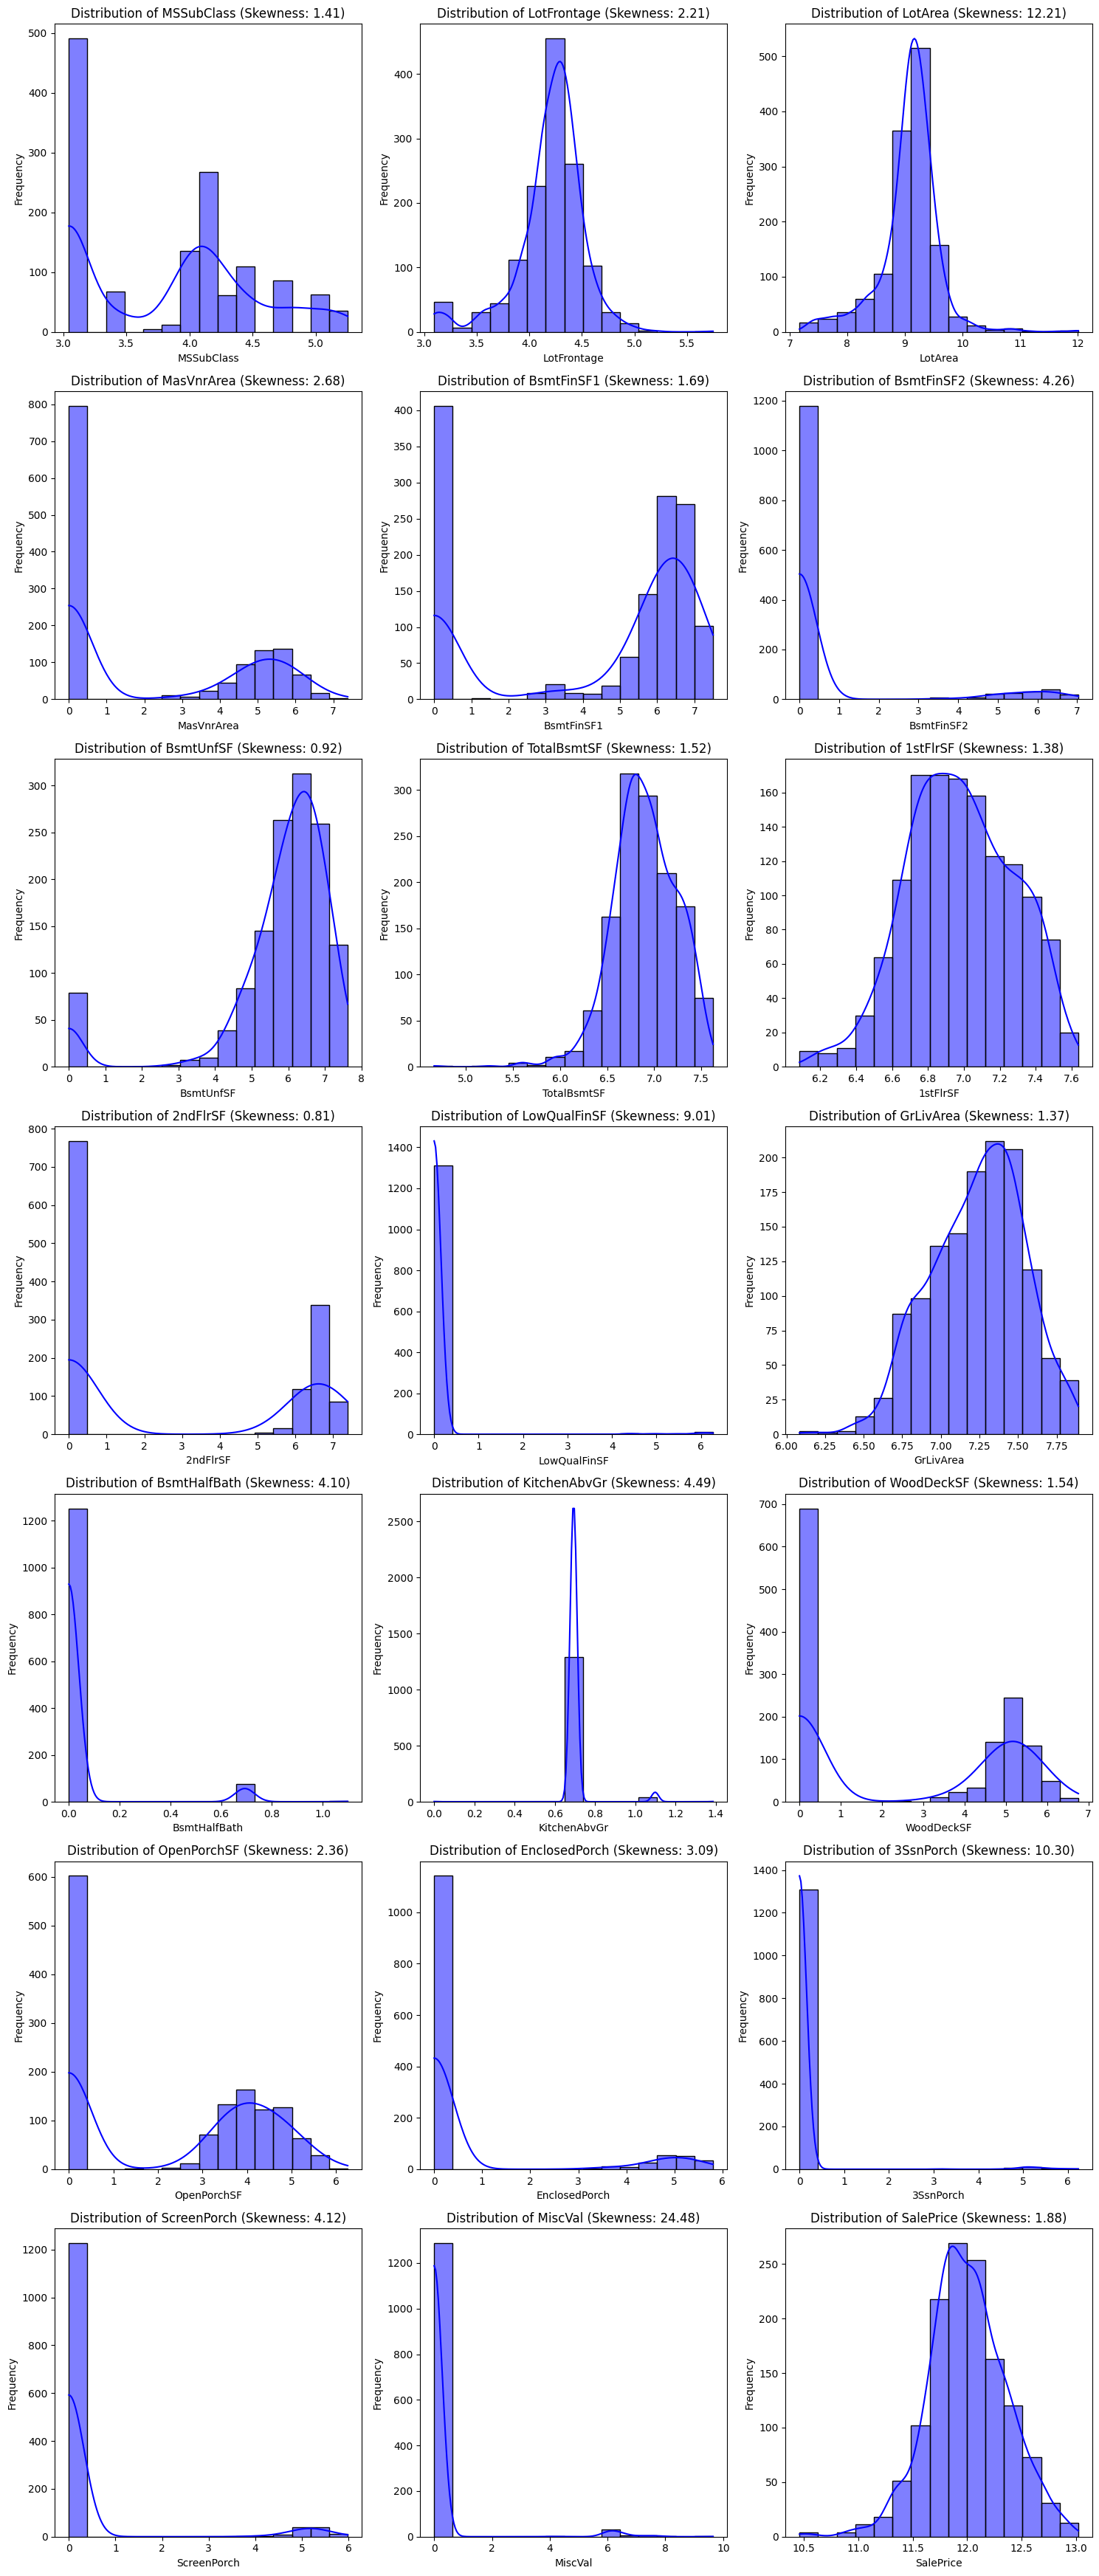

In [94]:

numerical_df = train[numerical_columns]
categorical_df = train[categorical_columns]
# Calculate the correlation matrix
correlation = numerical_df.corr()

# Select columns with high correlation to 'SalePrice'
high_corr_cols = correlation['SalePrice'][correlation['SalePrice'].abs() > 0.5].index.tolist()
high_corr_cols.remove('SalePrice')  # Exclude the target variable itself
print("Highly correlated columns:", high_corr_cols)


for col in high_corr_cols:
    Q1 = train[col].quantile(0.25)  # 25th percentile
    Q3 = train[col].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out rows outside bounds
    train = train[(train[col] >= lower_bound) & (train[col] <= upper_bound)]

print(f"Remaining rows train: {train.shape[0]}")
print(f"Remaining columns train: {train.shape[1]}")

print(f"Remaining rows test: {test.shape[0]}")
print(f"Remaining columns test: {test.shape[1]}")


# Identify skewed columns (optional: only apply to highly correlated ones)
skewness = numerical_df.skew()
skewed_cols = skewness[skewness.abs() > 0.75].index.tolist()
train[skewed_cols] = np.log1p(train[skewed_cols])
# Display skewed columns
print("Skewed columns:", skewed_cols)
# Set up the number of subplots
num_skewed = len(skewed_cols)
cols = 3  # Number of columns in the grid
rows = (num_skewed // cols) + (num_skewed % cols > 0)  # Calculate number of rows needed

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy indexing

# Plot each skewed column
for i, col in enumerate(skewed_cols):
    sns.histplot(train[col], kde=True, bins=15, color='blue', ax=axes[i])
    axes[i].set_title(f"Distribution of {col} (Skewness: {numerical_df[col].skew():.2f})")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [95]:
# # Check unique values for each column
# for col in categorical_columns:
#     print(f"{col}: {train[col].unique()}")
#All te categorical columns can be encoded here as all are ordinal

#Categorical Encoding
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
train[categorical_columns] = ordinal_encoder.fit_transform(train[categorical_columns])
test[categorical_columns] = ordinal_encoder.fit_transform(test[categorical_columns])

fill_blank(train)
fill_blank(test)

categorical_columns, numerical_columns = col_type(train)

missing_info= missing_val_show(train)



#Feature Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_features = numerical_columns
train[num_features] = scaler.fit_transform(train[num_features])

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
print(f"Minimum SalePrice: {train['SalePrice'].min()}")  # Check for non-positive values
train = train[train['SalePrice'] > 0]

X = train.drop('SalePrice', axis=1)  

#Remove low-variance features that don't contribute to prediction:
selector = VarianceThreshold(threshold=0.01)
X_transformed = selector.fit_transform(X)
selected_columns = X.columns[selector.get_support()]  # Get column names that were retained
X = pd.DataFrame(X_transformed, columns=selected_columns)


#for nominal data, use One-Hot Encoding instead:
X = pd.get_dummies(X, drop_first=True)
test = pd.get_dummies(test, drop_first=True)
#Align train and test datasets after encoding
X, test = X.align(test, join='inner', axis=1)

y = np.log1p(train['SalePrice']) 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# Check for NaN or Infinity
print(f"NaNs in y_train: {np.any(np.isnan(y_train))}")
print(f"Infinities in y_train: {np.any(np.isinf(y_train))}")


Categorical_cols: 0
Numerical_cols: 74
Empty DataFrame
Columns: [column_name, missing_count, missing_percentage]
Index: []
Minimum SalePrice: -4.265250873193239
NaNs in y_train: False
Infinities in y_train: False


In [103]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
top_features = importance.head(30).index.tolist()
X = X[top_features]
test = test[top_features]

y = np.log1p(train['SalePrice']) 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


#Combine multiple models using a Stacking Regressor
from sklearn.ensemble import StackingRegressor
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42))
]
stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking_model.fit(X_train, y_train)

# Predictions
y_pred_stack = stacking_model.predict(X_val)
y_pred_stack = np.expm1(y_pred_stack)

In [105]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Evaluate XGBoost
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = np.maximum(0, np.expm1(xgb.predict(X_val)))

rmsle = np.sqrt(mean_squared_log_error(np.expm1(y_val), xgb_pred))
print("RMSLE xgb:", rmsle)

xgb_r2 = r2_score(np.expm1(y_val), xgb_pred)
print("R² for XGBoost:", xgb_r2)

# Evaluate Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = np.maximum(0, np.expm1(rf.predict(X_val)))
rmsle = np.sqrt(mean_squared_log_error(np.expm1(y_val), rf_pred))
print("RMSLE rf:", rmsle)

xgb_r2 = r2_score(np.expm1(y_val), rf_pred)
print("R² for random forest:", xgb_r2)



rmsle = np.sqrt(mean_squared_log_error(np.expm1(y_val), y_pred_stack))
print("RMSLE:", rmsle)

print("MAE stack:", mean_absolute_error(np.expm1(y_val), y_pred_stack))
print("RMSE stack:", np.sqrt(mean_squared_error(np.expm1(y_val), y_pred_stack)))
print("R² Score stack:", r2_score(np.expm1(y_val), y_pred_stack))


RMSLE xgb: 0.14221056808313634
R² for XGBoost: 0.8294741768061038
RMSLE rf: 0.13707962083116015
R² for random forest: 0.83528432357244
RMSLE: 0.13575307130090083
MAE stack: 0.1929299687316001
RMSE stack: 0.25287428489823816
R² Score stack: 0.8435334246096831


In [106]:
y_pred=stacking_model.predict(test)
y_pred = np.maximum(0, y_pred)


submission = pd.DataFrame({
    'Id': test['Id'],  # Use the test dataset's IDs
    'SalePrice': y_pred  # Predicted prices
})
submission.to_csv('submission.csv', index=False)